Λαμπρόπουλος Κωνσταντίνος $$ $$
ΑΜ : 1115201800092

Imports

In [16]:
import pandas as pd
import numpy as np
from PIL import Image
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Load Image (Question 1)

In [17]:
def SetRange(set_number): #Set the aprropriate ranges for each set
    if set_number == 1: #not that the in range() function of python iterates over the [start,stop) range
        infimum,maximum = 1,8
    elif set_number == 2:
        infimum,maximum = 8,20
    elif set_number == 3:
        infimum,maximum = 20,32
    elif set_number == 4:
        infimum,maximum = 32,46
    elif set_number == 5:
        infimum,maximum = 46,65
    return (infimum,maximum)

In [18]:
def LoadImages(path,set_number): #load an image set
    loadedimages = [] #empty lists to store our variables
    labels = []
    start,stop = SetRange(set_number) #get the range of each set
    for i in range(1,11): #we will get a number of images from all people
        for j in range(start,stop): #but in each set we take different pictures from all people
            if i < 10: #images of people from 1-9 have format like this
                if j < 10: #e.g person03_09.png so we need to add the 0s to the path
                    image_path = f"{path}/person0{i}_0{j}.png"
                else:
                    image_path = f"{path}/person0{i}_{j}.png" 
            else: #else if it is the 10nth person,we dont need a 0 in the beggining
                if j < 10:
                    image_path = f"{path}/person{i}_0{j}.png"
                else:
                   image_path = f"{path}/person{i}_{j}.png" 
            image = Image.open(image_path) #open the image from the path
            loadedimages.append(np.array(image).flatten()) #get a vector from the image
            labels.append(i) #and add the according label
    return loadedimages,labels #retun a tuple

Train Eigen Faces

In [19]:
def TrainEigenFaces(train_data, train_labels, d):
    pca = PCA(n_components=d) #initialize PCA with the components we wnat
    data = pca.fit_transform(train_data) #project data to eigen space
    
    knn = KNeighborsClassifier(n_neighbors=1,p=2) #use Knn neighbours classifier
                                              #the classifier uses euclidiean distance metric when
                                              #variable p equals to 2
    knn.fit(data, train_labels) #fit the data

    return pca,knn,pca.components_ #return tuple

Test Eigen Faces

In [20]:
def TestEigenFaces(pca, knn, test_data):
    data = pca.transform(test_data) #project our test data to eigen space
    predicted_labels = knn.predict(data) #predict the image we are using
    return predicted_labels #return predictions

In [21]:
def ImageReconstrunction(eigenvectors,pca,image):
    vector = image.flatten() - pca.mean_ #convert the image to a vector and center it by removing the mean vector
    coefficients = [] #we need the coefficients to recontruct an image
    for eigenvector in eigenvectors: #for each eigenvector
        coefficient  = np.dot(vector,eigenvector) #calculate the coefficient
        coefficients.append(coefficient) #append it to the list
    np.array(coefficients) #make the list an array
    coefficients = np.reshape(coefficients,(len(pca.components_),1)) #we want the product of 2 arrays
    eigenvectors = np.transpose(eigenvectors) #so coefficients and eigenvectors need to be able to peform the operation
    vector = np.dot(eigenvectors,coefficients) #calculate the product
    recontructed_image = np.array(vector).reshape(50,50) #reshape the image to be 50x50 as the original
    return recontructed_image #return it


In [22]:
def ShowImage(image9,image30,image):
    plt.figure(figsize=(15,4)) #set figure size
    ax1 = plt.subplot(3,8,1) #sublot 1
    plt.imshow(image.reshape(50,50),cmap='bone') #original image
    ax1.set_title('Image') #title
    ax2 = plt.subplot(3,8,2) #sublot 2
    plt.imshow(image9,cmap='bone') #image with 9 eigenvectors used to reconstruct
    ax2.set_title('d=9') #title
    ax3 = plt.subplot(3,8,3) #sublot 3
    plt.imshow(image30,cmap='bone') #image with 30 eigenvectors used to reconstruct
    ax3.set_title('d=30') #title (for some reason not wotking when main title is added)
    plt.title('Image Reconstruction',x=-1.15,y=1.75,pad=-20) #set title
    plt.show()

Face Recognition

In [23]:
def FaceRecognition():
    train_data,train_labels = LoadImages('./faces',1) #load our training data
    pca,knn,eigenvectors = TrainEigenFaces(train_data,train_labels,9) #perform face recognition with 9 vectors first
    print("Accuracy Scores for 9 vectors")
    for i in range (1,6):
        test_data,test_labels = LoadImages('./faces',i) #load test sets
        if i == 2: #get a random image from the set (for image reconstruction)
            Image9 = ImageReconstrunction(eigenvectors,pca,test_data[i]) #reconstruct image  with 9 eigenvectors (for next question)
        predicted_labels = TestEigenFaces(pca,knn,test_data) #test each set
        print(f"Set {i} : {accuracy_score(predicted_labels,test_labels)*100:.6f}%") #print accuracy of predicitons
    pca,knn,eigenvectors_2 = TrainEigenFaces(train_data,train_labels,30) #perform face recognition with 30 vectors
    print("Accuracy Score for 30 vectors") 
    for i in range (1,6):
        test_data,test_labels = LoadImages('./faces',i) #load test sets
        if i == 2: #get the same image as on the previous iteration of the sets
            Image30 = ImageReconstrunction(eigenvectors_2,pca,test_data[i])
            image = test_data[i]
        predicted_labels = TestEigenFaces(pca,knn,test_data) #project set to eigen space and predict each image
        print(f"Set {i} : {accuracy_score(predicted_labels,test_labels)*100:.6f}%") #print accuracy
    return eigenvectors,Image9,Image30,image,train_data

Convert Eigen Vectors To Image

In [24]:
def EigenVectorToImage(eigenvectors):
    plt.figure(figsize=(9,4)) #set the figure size
    for i in range(1,10,1): #for each eigenvector
        plt.subplot(3,8,i) #create subplot-i
        plt.imshow(eigenvectors[i-1].reshape(50,50),cmap='bone') #show the eigenvector as an image of 50x50
    plt.title(label="EigenVectors converted back to images",x=4.5,y=3,pad=-15) #set
    plt.show()

Face Recognition Showcase (Question 2)

In [25]:
eigenvectors,image9,image30,image ,train_data= FaceRecognition() #Call the function to showcase the results

Accuracy Scores for 9 vectors
Set 1 : 100.000000%
Set 2 : 90.000000%
Set 3 : 42.500000%
Set 4 : 20.000000%
Set 5 : 14.736842%
Accuracy Score for 30 vectors
Set 1 : 100.000000%
Set 2 : 94.166667%
Set 3 : 50.833333%
Set 4 : 20.000000%
Set 5 : 14.736842%


Γενίκευση της μεθόδου στα διαφορετικά Sets

Παρατηρούμε ότι ενώ στο πρώτο και στο δεύτερο set υπάρχει αρκετά μεγάλη ακρίβεια στην αναγνώριση των προσώπων,στα υπόλοιπα μειώνεται αρκετά,μέχρις όπου στο set 5 έχουμε ποσοστό 14.736842%.Η κύρια διαφορά μεταξύ των Set είναι ο διαφορετικός φωτισμός που επικρατεί.Μπορούμε να γενικεύσουμε την μέθοδο EigenFaces και να την εκπαιδεύσουμε με τα διαφορετικά Sets.Βέβαια αν χρησιμοποιήσουμε ως train set ,πχ το set 5  θα έχουμε πάλι αρκετά μικρά ποσοστά στο set 1 και 2.Όμως αν αλλάζαμε την δομή των set ,όπου κάθε set περιείχε είκονες με διαφορετικό φωτισμό για κάθε πρόσωπο,θα ήταν δυνατό να πετύχουμε μεγαλύτερα ποσοστά ακρίβειας.

Eigen Vectors depicted as images (Question 3)

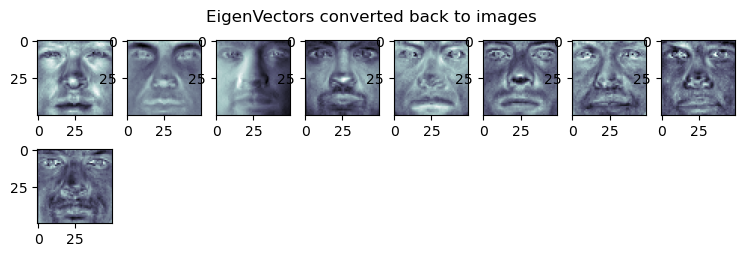

In [26]:
EigenVectorToImage(eigenvectors)

Τα ιδιοδιανύσματα αυτά εκφράζουν τις πιο σημαντικές αλλαγές στο train set.Ειδικότερα
πιάνουν τις εναλλαγές στον φωτισμό και στις εκφράσεις του προσώπου

Image Reconstruction (Question 4)

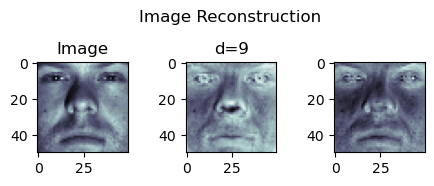

In [27]:
ShowImage(image9,image30,image)

Παρατηρούμε ότι η ανακατασκευή της εικόνας χρησιμοποιώντας 9 ιδιοδιανύσματα δεν έχει τόσο μεγάλη ακρίβεια στον φωτισμό και δεν έχει πετύχει τις έντονες εναλλαγές φωτός πάνω στο πρόσωπο(όπως στη μύτη,χείλη,φρύδια,μάτια) το οποίο κάνει την ανακατασκευή να μην είναι τόσο αληθοφανής.Αντίθετα η ανακατασκευή με 30 ιδιοδιανύσματα φαίνεται ότι έχει πετύχει καλύτερα τον φωτισμό ,αφού τώρα τα χαρακτηριστικά στα οποία υστερούσε η ανακατασκευή με d=9 είναι πολύ πιο αληθοφανή.Ακόμα βέβαια υπάρχουν κάποια θέματα,όπως είναι τα μάτια και ότι έχει αποδόσει πιο σκοτεινό χρώμα στο πρόσωπο.

Display Singular Vectors (Question 5)

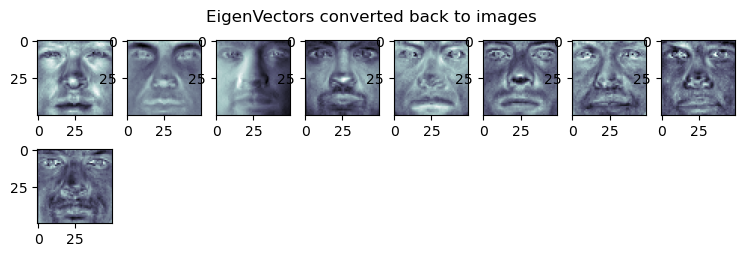

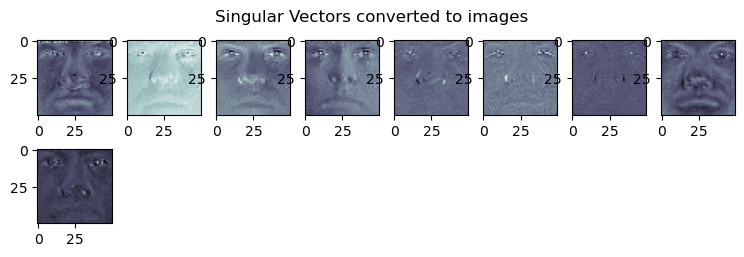

In [28]:
train_data = np.array(train_data)
train_data = train_data.transpose()
singular_vectors,s,vt = np.linalg.svd(train_data)
EigenVectorToImage(eigenvectors)
plt.figure(figsize=(9,4)) #set the figure size
for i in range(1,10,1): #for each eigenvector
    plt.subplot(3,8,i) #create subplot-i
    plt.imshow(singular_vectors[i-1].reshape(50,50),cmap='bone') #show the eigenvector as an image of 50x50
plt.title(label="Singular Vectors converted to images",x=4.5,y=3,pad=-15) #set
plt.show()


Παρατηρούμε ότι τα Singular Vectors και τα Eigen Vectors διαφέρουν αρκετά.Ο λόγος πίσω από αυτό είναι ότι ενώ τα Eigen Vectors δείχνουν τα σταθερά κομμάτια των εικόνων (invariant) τα οποία δεν αλλάζουν,τα Singular Vectors δείχουν τις μεγαλύτερες εναλλαγές ,όπως εδώ είναι ο φωτισμός.

Classification using SVMs

Imports

In [29]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
#no cuda drivers found (RTX 3080 btw)

Load and Normalize the Data

In [30]:
(x_train,y_train),(x_test,y_test )= mnist.load_data() #load the dataset
                                                      #the dataset is automatically split in a train set
                                                      #of 60000 and a test set of 10000
x_train = x_train.reshape(-1,28*28)
x_test = x_test.reshape(-1,28*28)
scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.fit_transform(x_test)   

SVC on the full Image

In [31]:
svm = SVC(kernel='rbf',gamma='scale',C=100.0) #initialize the model with correct parameters
                                              
svm.fit(x_train,y_train) #fit the train set to the model
y_pred = svm.predict(x_test) #predict the test set
print("Accuracy:", accuracy_score(y_test, y_pred)) #print accuracy score

Accuracy: 0.9834


Στο παραπάνω testing χρησιμοποιήθηκαν οι παράμμετροι : kernel = rbf,gamma = scale,C=100.0 και απέδωσαν ακρίβεια 98.33%

SVM with PCA with 10 components

In [32]:
pca = PCA(n_components=10)
x_train_transformed = pca.fit_transform(x_train)
x_test_transformed = pca.fit_transform(x_test)
svm = SVC(kernel='rbf',gamma='scale',C=100.0) #97.6 with kernel rbf gamma auto and C = 100
                                              #98.33 with rbf scale C=100.0
svm.fit(x_train_transformed,y_train)
y_pred = svm.predict(x_test_transformed)                                            
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.1235


Κρατώντας 10 components από τη μέθοδο PCA,υπάρχει ακρίβεια της τάξης του 12.34% σε χρόνο 18.6s

SVM with PCA with 100 components

In [33]:
pca = PCA(n_components=100)
x_train_transformed = pca.fit_transform(x_train)
x_test_transformed = pca.fit_transform(x_test)
svm = SVC(kernel='rbf',gamma='scale',C=100.0) #97.6 with kernel rbf gamma auto and C = 100
                                              #98.33 with rbf scale C=100.0
svm.fit(x_train_transformed,y_train)
y_pred = svm.predict(x_test_transformed)                                            
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.1333


Κρατώντας 100 components υπάρχει ακρίβεια της τάξης του 13.34% σε χρόνο 47.2s

SVM with PCA with 300 components

In [34]:
pca = PCA(n_components=300)
x_train_transformed = pca.fit_transform(x_train)
x_test_transformed = pca.fit_transform(x_test)
svm = SVC(kernel='rbf',gamma='scale',C=100.0) #97.6 with kernel rbf gamma auto and C = 100
                                              #98.33 with rbf scale C=100.0
svm.fit(x_train_transformed,y_train)
y_pred = svm.predict(x_test_transformed)                                            
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.1332


Κρατώντας 300 components υπάρχει ακρίβεια της τάξης του 13.34% σε χρόνο 2 minutes,4.9s

SVM with PCA with 500 components

In [35]:
pca = PCA(n_components=500)
x_train_transformed = pca.fit_transform(x_train)
x_test_transformed = pca.fit_transform(x_test)
svm = SVC(kernel='rbf',gamma='scale',C=100.0) #97.6 with kernel rbf gamma auto and C = 100
                                              #98.33 with rbf scale C=100.0
svm.fit(x_train_transformed,y_train)
y_pred = svm.predict(x_test_transformed)                                            
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.1338


Κρατώντας 500 components υπάρχει ακρίβεια της τάξης του 13.37% σε χρόνο 2 minutes,51.9s

Παρατηρούμε ότι χωρίς την εφαρμογή του Principal Component Analysis ,ο SVC τρέχει σε 3 minutes και 13.4s,που είναι 20 δευτερόλεπτα περίπου παραπάνω από το να χρησιμοποιήσουμε PCA για 500 components.Όμως υπάρχει τόσο σημαντική διαφορά στην ακρίβεια ταξινόμησης που δεν αξίζει να γλυτώσουμε τα 20 δευτερόλεπτα αυτά,αφού χωρίς τον αλγόριθμο pca έχουμε ακρίβεια της τάξης του 98.34% ενώ με τον αλγόριθμο pca κρατώντας 500 components από τα 784 έχουμε 13.38%